In [48]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Seminar 1 - Linear Regression

Javier González Otero - 243078

Jordi Guillén González - 253027

David Sánchez Maldonado - 253798

## Info

contention window -> es como el tiempo máximo de cola que un paquete debe hacer para poder ser enviado. Al enviar un paquete se escoge un backoff random entre 0 y contention window, entonces, se envia primero el paquete con backof mas pequeño y se van enviando por orden. Si es muy peque para el numero de paquetes a enviar entonces podemos tener colisiones, lo que implica reenvio del paquete, si es muy grande, esperaremos de más, pero evitamos colisiones.

chanel width -> contra más grande, más variabilidad de datos pueden enviarse al mismo tiempo, cada cosa que se envia, se envia a una frecuencia distinta

packet size -> tenemos que si es muy grande, podemos transmitir más datos si además el channel width es grande y tenemos pocos overheads (la proporcion de datos en cada  paquete es grande). El tema es que si lo perdemos, tenemos que volver a enviar todo el paquete, por tanto, si nuestra red no es muy segura en ese aspecto, conviene tener paquetes más pequeños

RSSI -> es lo del netspot, osea la intensidad de la señal. Tenemos el máximo, el minimo y el avg

Throughput -> Cantidad total de datos que se envian exitosamente (datos salientes) a través de la red por segundo bits por segundo

## Part 1 - Data Preparation & EDA

### Data preparation and cleaning

In [34]:
# Path to file containing data
file_path = "data/dataset_Seminar1.txt"

# Column names
column_names = [
    "num_STAs", "load_Mbps", "size_x_m", "size_y_m", "area_m2",
    "cw_slots", "channel_width_MHz", "packet_size_bits",
    "max_RSSI_dBm", "avg_RSSI_dBm", "min_RSSI_dBm",
    "avg_prob_failure", "throughput_bps", "avg_delay_s",
    "total_airtime_s", "prop_airtime"
]

# Load data into a pandas dataframe
dataframe = pd.read_csv(file_path, sep=r'\s+', header=None, names=column_names)

# Drop unwanted columns
columns_to_drop = ["avg_prob_failure", "avg_delay_s", "total_airtime_s", "prop_airtime"]
dataframe = dataframe.drop(columns=columns_to_drop)

# Original values for each "categorical numeric" variable
cw_values = sorted(dataframe["cw_slots"].unique())
channel_width_values = sorted(dataframe["channel_width_MHz"].unique())
packet_size_values = sorted(dataframe["packet_size_bits"].unique())

In [35]:
# Check for missing values
null_counts = dataframe.isnull().sum()
print("Missing values per column:\n", null_counts)

Missing values per column:
 num_STAs             0
load_Mbps            0
size_x_m             0
size_y_m             0
area_m2              0
cw_slots             0
channel_width_MHz    0
packet_size_bits     0
max_RSSI_dBm         0
avg_RSSI_dBm         0
min_RSSI_dBm         0
throughput_bps       0
dtype: int64


### Data statistics

In [36]:
dataframe.describe()

,num_STAs,load_Mbps,size_x_m,size_y_m,area_m2,cw_slots,channel_width_MHz,packet_size_bits,max_RSSI_dBm,avg_RSSI_dBm,min_RSSI_dBm,throughput_bps
count,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05
mean,21.446170,2.140292e+07,20.562940,20.479640,421.270350,227.043920,75.106000,7997.580000,-45.911165,-57.577426,-66.467827,9.716009e+06
std,11.554365,1.852042e+07,11.545206,11.540626,360.344349,323.350855,53.704279,2825.532513,5.400265,6.108548,8.057528,4.958025e+06
min,2.000000,5.000000e+05,1.000000,1.000000,1.000000,3.000000,20.000000,4000.000000,-81.405165,-81.405165,-84.333834,5.000000e+05
25%,11.000000,7.250000e+06,11.000000,11.000000,120.000000,15.000000,20.000000,6000.000000,-48.131476,-61.985000,-72.637078,6.187692e+06
50%,21.000000,1.600000e+07,21.000000,20.000000,320.000000,63.000000,80.000000,8000.000000,-44.111064,-58.163205,-67.997587,9.113764e+06
75%,31.000000,3.000000e+07,31.000000,30.000000,640.000000,255.000000,160.000000,10000.000000,-41.888821,-53.589525,-61.525848,1.343290e+07
max,41.000000,8.200000e+07,40.000000,40.000000,1600.000000,1023.000000,160.000000,12000.000000,-40.863587,-40.865960,-40.865960,2.262273e+07


### Separate continuous and discrete variables

In [37]:
continuous_variables = ['num_STAs', 'load_Mbps', 'size_x_m', 'size_y_m', 'area_m2', 'max_RSSI_dBm', 'avg_RSSI_dBm', 'min_RSSI_dBm', 'throughput_bps']
discrete_variables = ['cw_slots', 'channel_width_MHz', 'packet_size_bits']

### Check the distribution of all variables without normalization

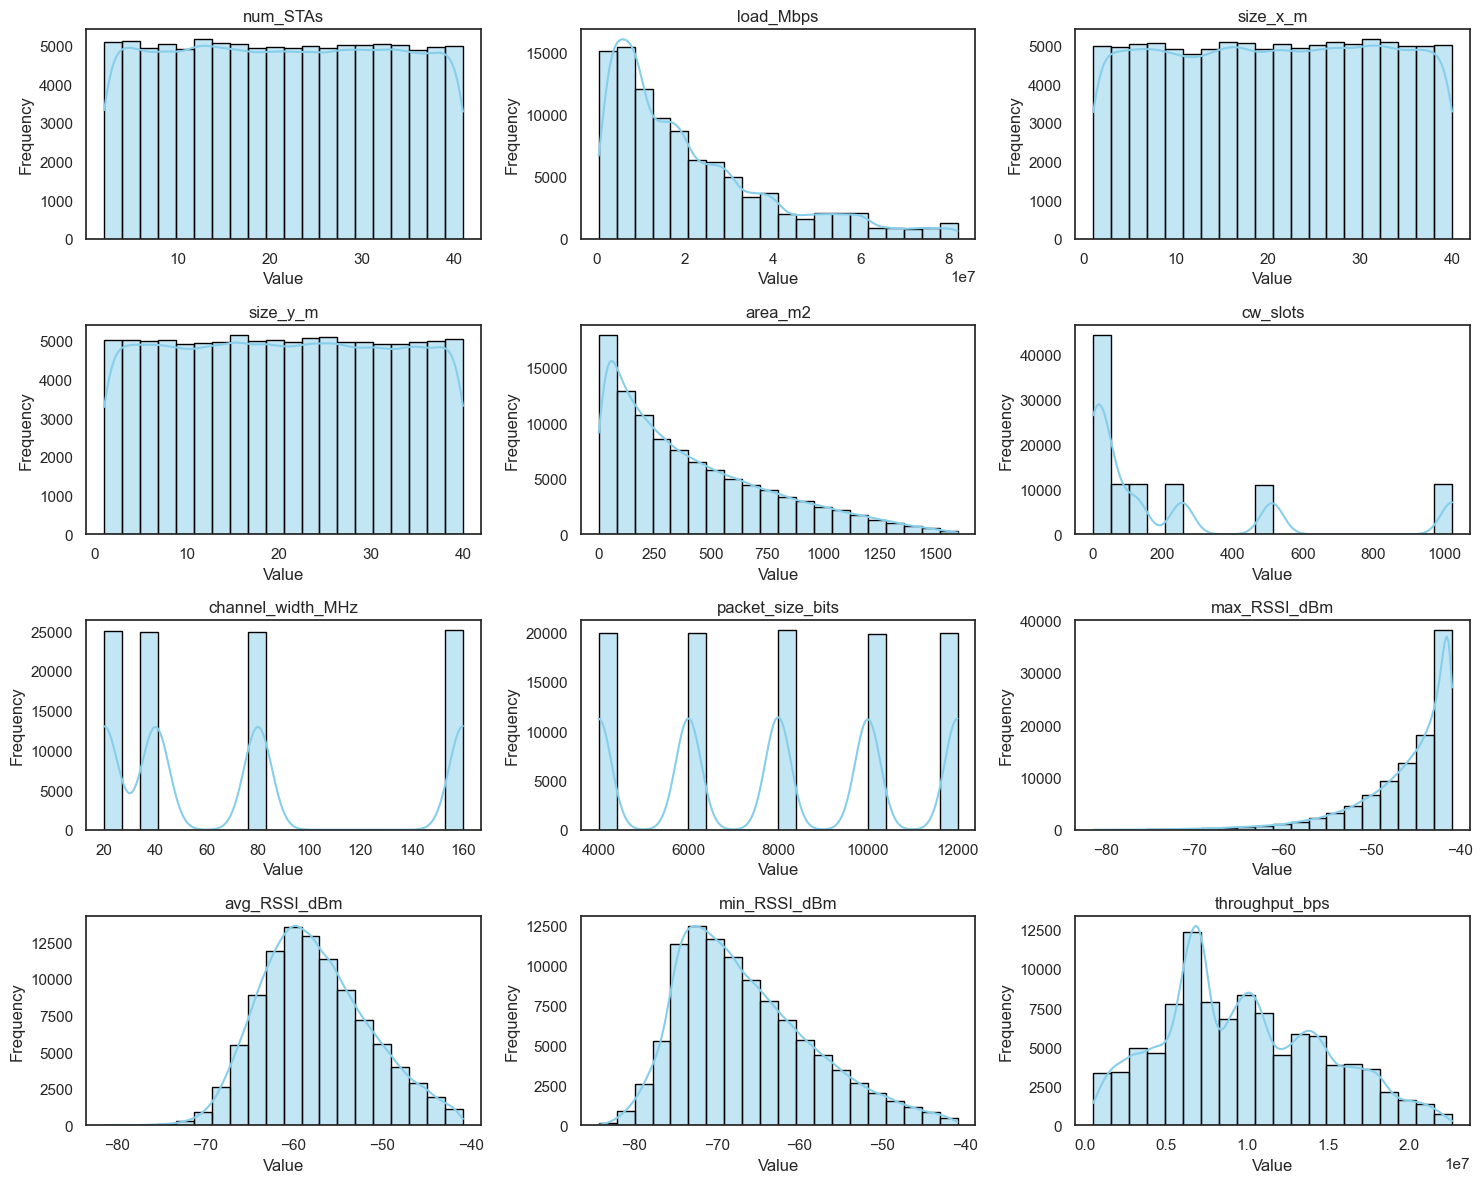

In [38]:
# Columns to plot
columns_to_plot = dataframe.columns.tolist()

# Create figure and axes
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
axes = axes.flatten()

# Plot histogram + KDE
for i, col in enumerate(columns_to_plot):
    sns.histplot(dataframe[col], bins=20, kde=True, ax=axes[i], color='skyblue', edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

# Hide any unused axes
for j in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Normalize data to compare distributions

In [39]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply normalization to the entire DataFrame
normalized_data = scaler.fit_transform(dataframe)

# Convert the result back to a pandas DataFrame with the original column names
normalized_df = pd.DataFrame(normalized_data, columns=dataframe.columns)

# Normalized values for each "discrete numeric" variable
normalized_cw_values = sorted(normalized_df["cw_slots"].unique())
normalized_channel_width_values = sorted(normalized_df["channel_width_MHz"].unique())
normalized_packet_size_values = sorted(normalized_df["packet_size_bits"].unique())

In [40]:
# Mapping of discrete variables to original values (normalized value : original value)
cw_mapping = {norm_val: orig_val for norm_val, orig_val in zip(normalized_cw_values, cw_values)}
channel_width_mapping = {norm_val: orig_val for norm_val, orig_val in zip(normalized_channel_width_values, channel_width_values)}
packet_size_mapping = {norm_val: orig_val for norm_val, orig_val in zip(normalized_packet_size_values, packet_size_values)}

### Compare density of continuous variables with target (throughput)

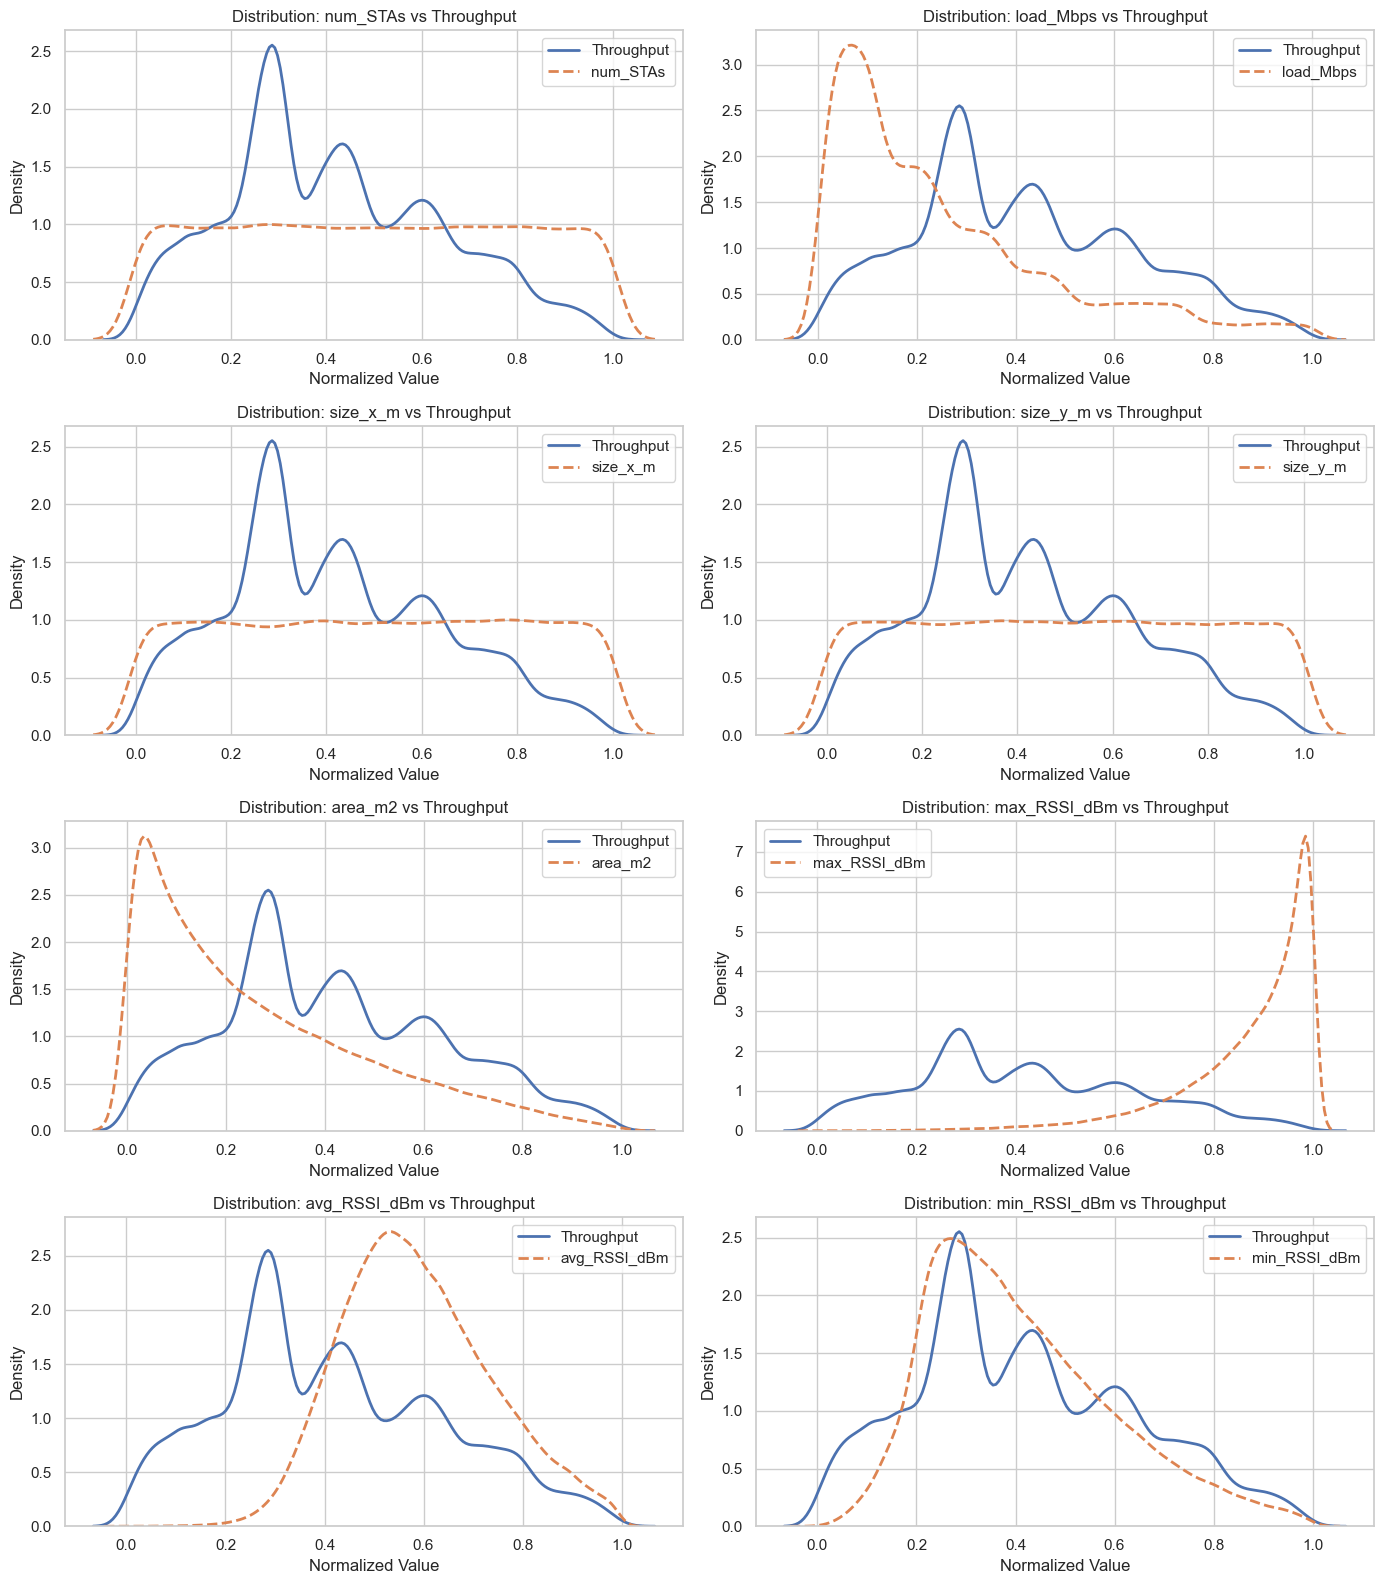

In [41]:
# Set plot style for better aesthetics
sns.set(style="whitegrid")

# Create a 4x2 subplot grid (8 total)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 16))
axes = axes.flatten()

# Plot KDEs of each continuous variable compared to throughput
for i, variable in enumerate(continuous_variables[:-1]):
    ax = axes[i]
    
    # Plot throughput distribution (solid line)
    sns.kdeplot(data=normalized_df, x="throughput_bps", label="Throughput", ax=ax, linewidth=2)
    
    # Plot current variable distribution (dashed line)
    sns.kdeplot(data=normalized_df, x=variable, label=variable, ax=ax, linestyle="--", linewidth=2)
    
    # Titles and labels
    ax.set_title(f'Distribution: {variable} vs Throughput', fontsize=12)
    ax.set_xlabel("Normalized Value")
    ax.set_ylabel("Density")
    ax.legend()

# Remove any unused subplots
if len(continuous_variables) < len(axes):
    for j in range(len(continuous_variables), len(axes)):
        fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### Compare distribution of throughput fixing different values of discrete variables

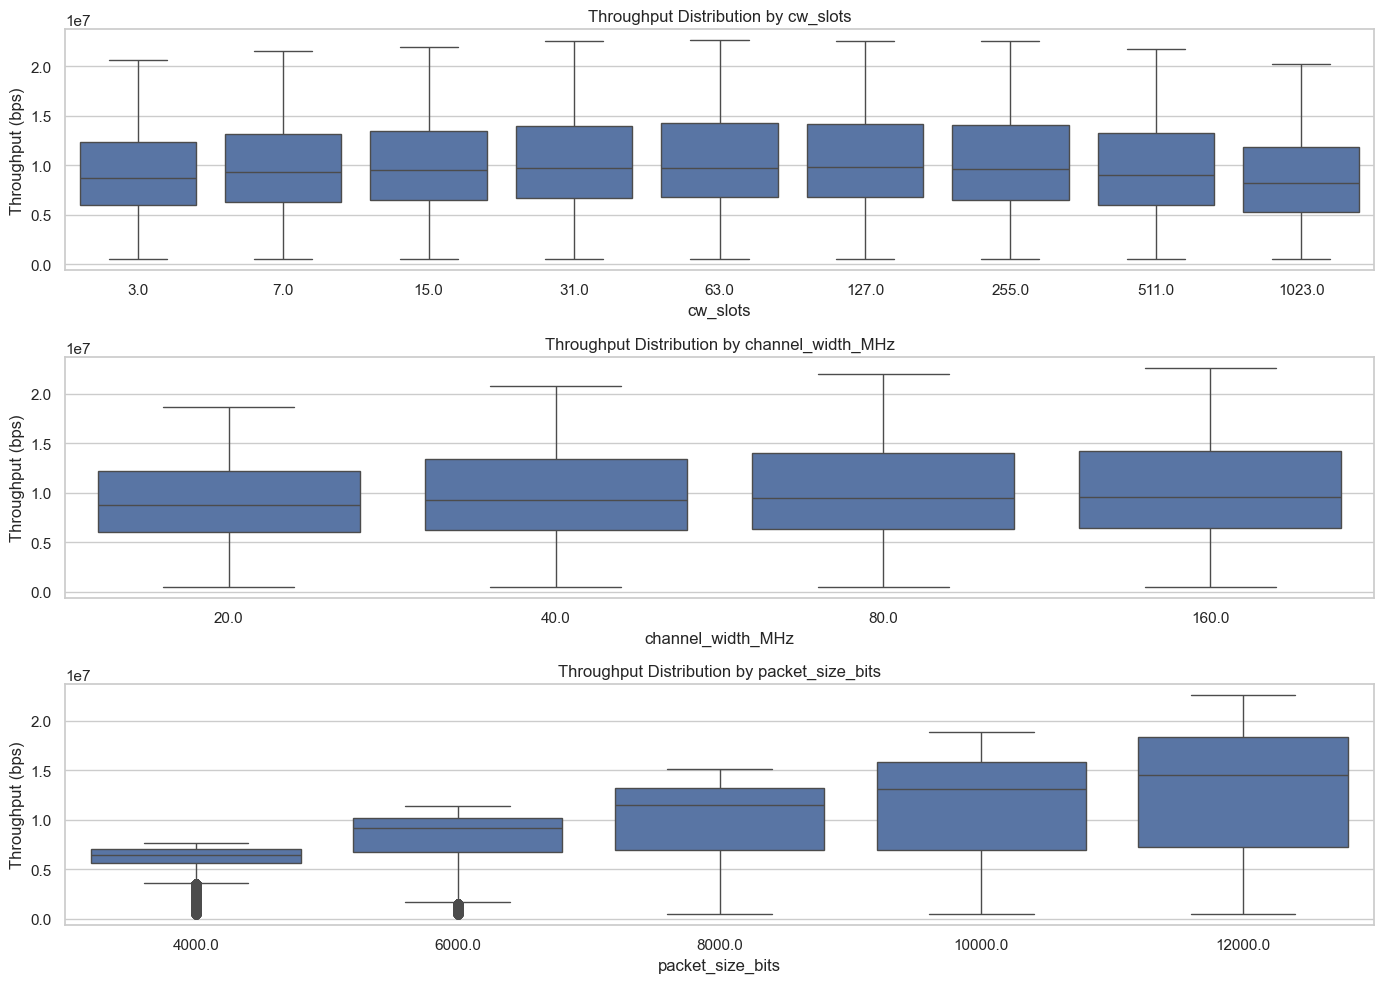

In [42]:
# Set plot style
sns.set(style="whitegrid")

# List of discrete variables
discrete_variables = ["cw_slots", "channel_width_MHz", "packet_size_bits"]

# Create one plot per discrete variable
fig, axes = plt.subplots(nrows=len(discrete_variables), figsize=(14, 10), sharey=True)

for i, var in enumerate(discrete_variables):
    ax = axes[i]
    
    sns.boxplot(data=dataframe, x=var, y="throughput_bps", ax=ax)
    
    ax.set_title(f"Throughput Distribution by {var}", fontsize=12)
    ax.set_xlabel(var)
    ax.set_ylabel("Throughput (bps)")

plt.tight_layout()
plt.show()

Aqui, se ve que la unica que realmente aporta info util es packet size bits, ya que es la que mas variabilidad ofrece intra valores. Las demás variables casi no presentan diferencias en la distribucioin de throughput

### Correlation heatmap

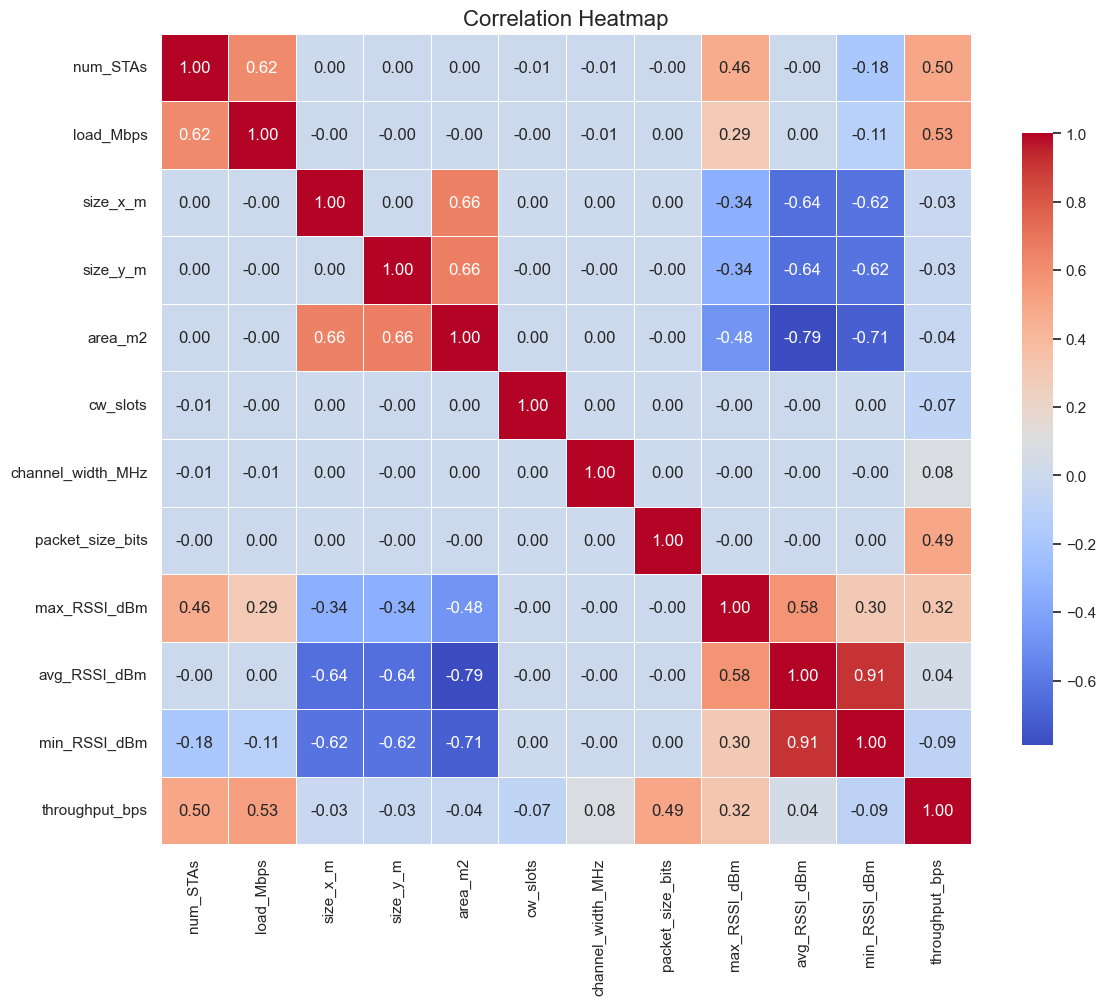

In [43]:
# Calculate correlation matrix
correlation_matrix = normalized_df.corr(numeric_only=True)

# Set plot size and style
plt.figure(figsize=(12, 10))
sns.set(style="white")

# Create heatmap
sns.heatmap(
    correlation_matrix,
    annot=True,         # show correlation values
    fmt=".2f",          # format to 2 decimal places
    cmap="coolwarm",    # color map
    square=True,        # square cells
    linewidths=0.5,     # line between boxes
    cbar_kws={"shrink": .75}
)

plt.title("Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.show()

### Split the data to be used in a ML model

In [45]:
# Define X (features) and y (target)
X = dataframe.drop(columns=["throughput_bps"])
y = dataframe["throughput_bps"]

In [46]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,        # 20% test, 80% train
    random_state=42,      # for reproducibility
    shuffle=True
)

## Part 2: Model implementation (repasar porque es un ñordo por ahora)

In [52]:
# Create the model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

LinearRegression()

In [53]:
# Predict on both train and test
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Compute error metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train MSE: {train_mse:.2f}")
print(f"Test MSE: {test_mse:.2f}")
print(f"Test R² Score: {test_r2:.4f}")

Train MSE: 9881948676837.49
Test MSE: 10020542477466.04
Test R² Score: 0.5939


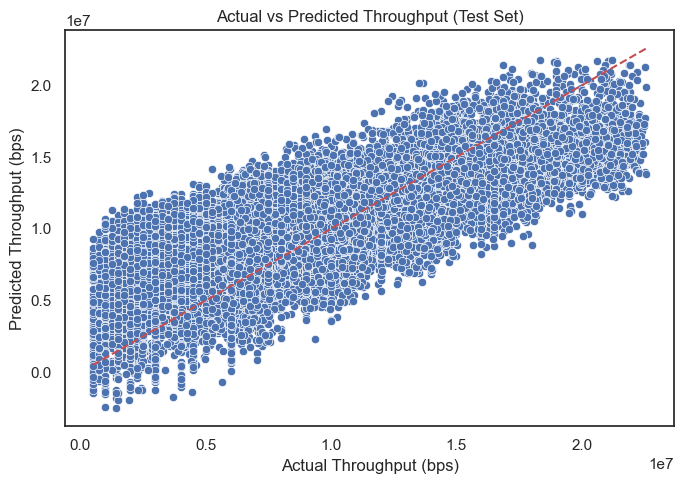

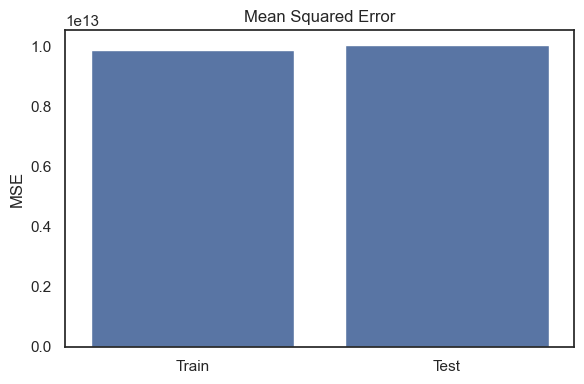

In [54]:
# Scatter plot: Real vs Predicted
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal line
plt.xlabel("Actual Throughput (bps)")
plt.ylabel("Predicted Throughput (bps)")
plt.title("Actual vs Predicted Throughput (Test Set)")
plt.tight_layout()
plt.show()

# Bar plot of MSE
plt.figure(figsize=(6, 4))
sns.barplot(x=["Train", "Test"], y=[train_mse, test_mse])
plt.title("Mean Squared Error")
plt.ylabel("MSE")
plt.tight_layout()
plt.show()